# Fraud Detection Predicting Model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Load dataset
df1 = pd.read_csv("synthetic_fraud_dataset.csv")
df1.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


The dataset given is synethic and can be a little too predictable. We dirty it.

In [3]:
df = df1.copy()

# Add small Gaussian noise to numeric features
numeric_cols = df.select_dtypes(include=['number']).columns.drop('Fraud_Label')
for col in numeric_cols:
    noise = np.random.normal(0, 0.05 * df[col].std(), size=len(df))
    df[col] += noise

# Enforce valid ranges and types
if 'Transaction_Amount' in df.columns:
    df['Transaction_Amount'] = df['Transaction_Amount'].clip(lower=0)

if 'Risk_Score' in df.columns:
    # Convert intervals to midpoint if needed
    df['Risk_Score'] = df['Risk_Score'].apply(
        lambda x: x.mid if isinstance(x, pd.Interval) else x
    )
    # Now clip safely
    df['Risk_Score'] = df['Risk_Score'].clip(lower=0, upper=1.0)

if 'IP_Address_Flag' in df.columns:
    df['IP_Address_Flag'] = np.random.choice([0, 1], size=len(df), p=[0.95, 0.05])

if 'Previous_Fraudulent_Activity' in df.columns:
    df['Previous_Fraudulent_Activity'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])

if 'Daily_Transaction_Count' in df.columns:
    df['Daily_Transaction_Count'] = df['Daily_Transaction_Count'].round().clip(lower=0)

if 'Avg_Transaction_Amount_7d' in df.columns:
    df['Avg_Transaction_Amount_7d'] = df['Avg_Transaction_Amount_7d'].clip(lower=0)

if 'Failed_Transaction_Count_7d' in df.columns:
    df['Failed_Transaction_Count_7d'] = df['Failed_Transaction_Count_7d'].round().clip(0, 4)

if 'Card_Age' in df.columns:
    df['Card_Age'] = df['Card_Age'].round().clip(lower=0)

if 'Transaction_Distance' in df.columns:
    df['Transaction_Distance'] = df['Transaction_Distance'].clip(lower=0)

if 'Is_Weekend' in df.columns:
    df['Is_Weekend'] = np.random.choice([0, 1], size=len(df), p=[0.7, 0.3])

# Flip 3% of the labels to simulate noise/mislabeling
flip_indices = df.sample(frac=0.03, random_state=42).index
df.loc[flip_indices, 'Fraud_Label'] = 1 - df.loc[flip_indices, 'Fraud_Label']

# Inject outliers into Transaction_Amount
if 'Transaction_Amount' in df.columns:
    outlier_indices = df.sample(frac=0.01, random_state=1).index
    df.loc[outlier_indices, 'Transaction_Amount'] *= np.random.randint(5, 10)

# Randomly drop 1% of values in each numeric column
for col in numeric_cols:
    missing_indices = df.sample(frac=0.01, random_state=0).index
    df.loc[missing_indices, col] = np.nan

# Export to file
df.to_csv("improved_dirty_fraud_dataset.csv", index=False)
print("Dirty version of synthetic dataset created")


Dirty version of synthetic dataset created


Removing NULL/NA values

In [4]:
df.dropna(inplace=True)

Checking for duplicates

In [5]:
df.duplicated().sum()

np.int64(0)

Getting rid of outliers

In [6]:
binary_cols = ["IP_Address_Flag", "Previous_Fraudulent_Activity", "Is_Weekend"]
iqr_cols = [col for col in numeric_cols if col not in binary_cols]

for col in iqr_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]


# Return the new shape after removing outliers
df.shape[0], df.shape[0]  # before and after row counts

(47100, 47100)

In [7]:
df["Transaction_ID"].duplicated().sum()

np.int64(0)

In [7]:
# Define X and y from your DataFrame
X = df.drop(columns=['Fraud_Label'])
y = df['Fraud_Label']

# Check for object or string columns before doing anything
print("Non-numeric columns in X before scaling:")
print(X.select_dtypes(include=['object', 'string']).columns)


Non-numeric columns in X before scaling:
Index(['Transaction_ID', 'User_ID', 'Transaction_Type', 'Timestamp',
       'Device_Type', 'Location', 'Merchant_Category', 'Card_Type',
       'Authentication_Method'],
      dtype='object')


## Visual Analysis of Fraud Patterns
The following graphs show patterns that helped design the rule-based fraud detection system.

In [8]:
# Drop the target column to define X
X = df.drop(columns=['Fraud_Label'])

# Drop all non-numeric columns
X = X.drop(columns=['Transaction_ID', 'User_ID', 'Transaction_Type', 'Timestamp',
                    'Device_Type', 'Location', 'Merchant_Category',
                    'Card_Type', 'Authentication_Method'])

y = df['Fraud_Label']

# Train-test split by 50% to train and test and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Optional scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
important_features = feature_importances.sort_values(ascending=False).head(10)

print('\nTop 10 Important Features:')
print(important_features)


Top 10 Important Features:
Failed_Transaction_Count_7d     0.487768
Risk_Score                      0.377549
Account_Balance                 0.024769
Transaction_Distance            0.024439
Avg_Transaction_Amount_7d       0.023990
Transaction_Amount              0.023799
Card_Age                        0.020635
Daily_Transaction_Count         0.011172
Is_Weekend                      0.002638
Previous_Fraudulent_Activity    0.002027
dtype: float64


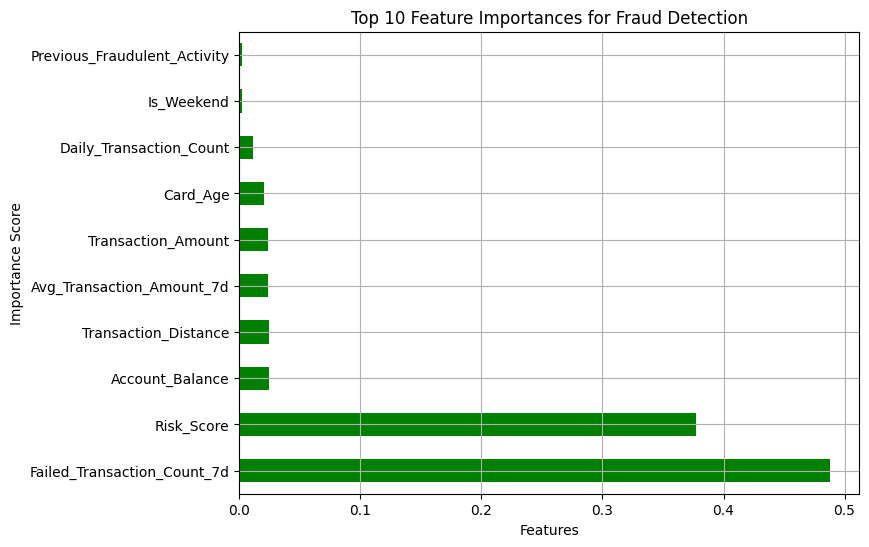

In [10]:
# Visualization of feature importance
plt.figure(figsize=(8, 6))
important_features.plot(kind='barh', color='green')
plt.title('Top 10 Feature Importances for Fraud Detection')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.grid(True)
plt.show()

In [11]:
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0, 1]
    print(f"Correlation with Fraud_Label - {col}: {corr:.4f}")


Correlation with Fraud_Label - Transaction_Amount: -0.0035
Correlation with Fraud_Label - Account_Balance: -0.0008
Correlation with Fraud_Label - IP_Address_Flag: 0.0020
Correlation with Fraud_Label - Previous_Fraudulent_Activity: -0.0044
Correlation with Fraud_Label - Daily_Transaction_Count: -0.0095
Correlation with Fraud_Label - Avg_Transaction_Amount_7d: 0.0020
Correlation with Fraud_Label - Failed_Transaction_Count_7d: 0.4733
Correlation with Fraud_Label - Card_Age: -0.0067
Correlation with Fraud_Label - Transaction_Distance: 0.0006
Correlation with Fraud_Label - Risk_Score: 0.3620
Correlation with Fraud_Label - Is_Weekend: -0.0043


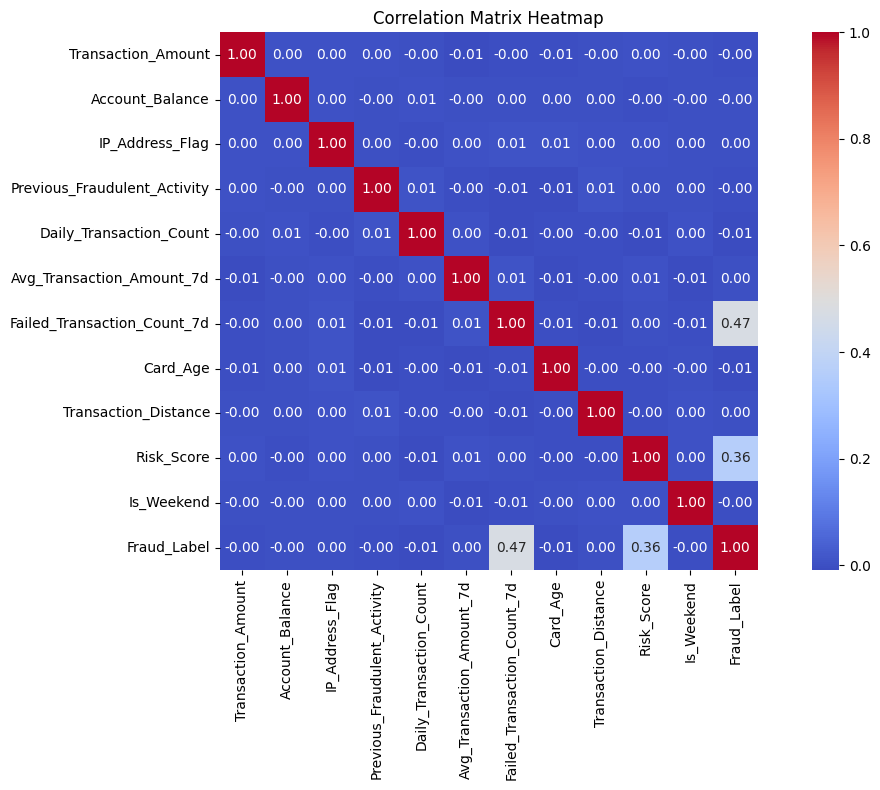

In [12]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])
# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

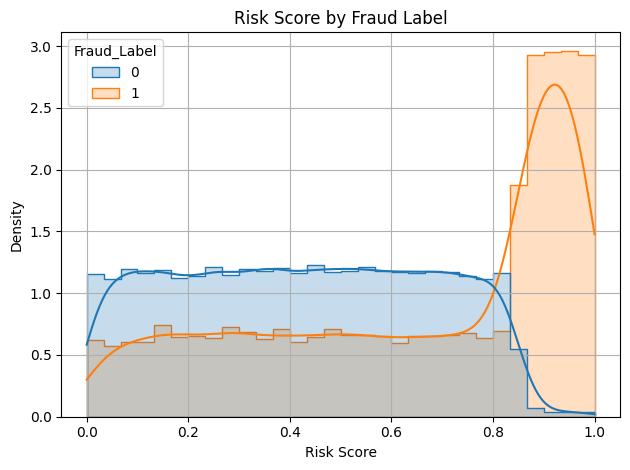

In [13]:
df["Hour"] = pd.to_datetime(df["Timestamp"]).dt.hour
sns.histplot(data=df, x="Risk_Score", hue="Fraud_Label", bins=30, kde=True, element="step", stat="density", common_norm=False)
plt.title("Risk Score by Fraud Label")
plt.xlabel("Risk Score")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** Fraudulent transactions are highly concentrated at risk scores above 0.8 and sharply spike at nearly 1.0.

C:\Users\phamr\AppData\Local\Temp\ipykernel_22988\1846336678.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df.groupby("Amount_Bin")["Fraud_Label"].mean().reset_index()


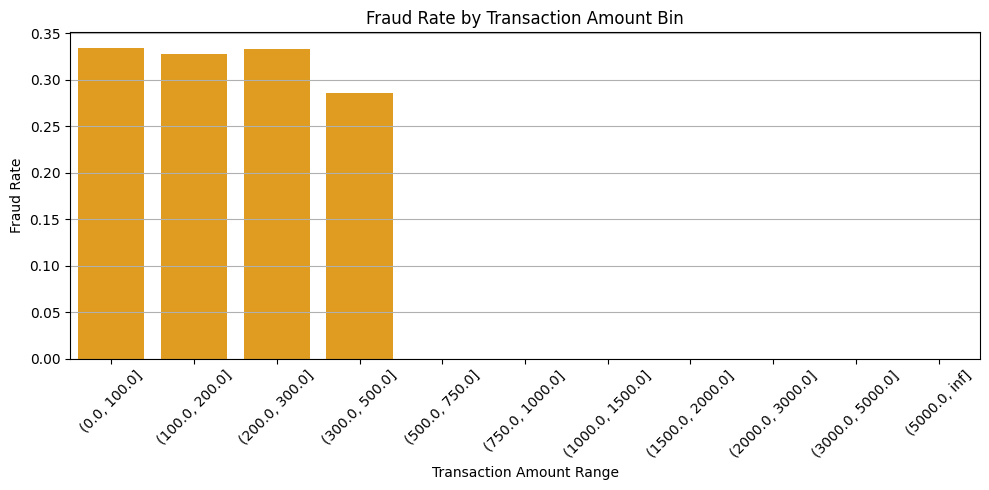

In [14]:
# Create a new column with binned transaction amounts
df["Amount_Bin"] = pd.cut(df["Transaction_Amount"], bins=[0, 100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, np.inf])

# Calculate fraud rate in each bin
fraud_rate_by_bin = df.groupby("Amount_Bin")["Fraud_Label"].mean().reset_index()
fraud_rate_by_bin.columns = ["Transaction Amount Bin", "Fraud Rate"]

# Plot fraud rate by transaction amount bin
plt.figure(figsize=(10, 5))
sns.barplot(data=fraud_rate_by_bin, x="Transaction Amount Bin", y="Fraud Rate", color="orange")
plt.xticks(rotation=45)
plt.title("Fraud Rate by Transaction Amount Bin")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Amount Range")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

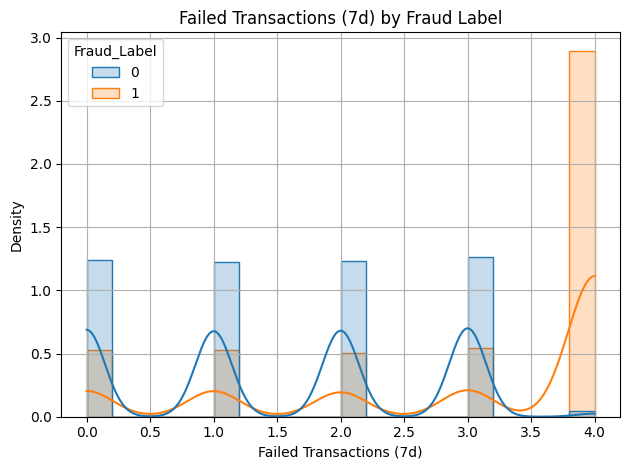

In [15]:
sns.histplot(data=df, x="Failed_Transaction_Count_7d", hue="Fraud_Label", bins=20, kde=True, element="step", stat="density", common_norm=False)
plt.title("Failed Transactions (7d) by Fraud Label")
plt.xlabel("Failed Transactions (7d)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** Fraud is more likely when a user has more than 3 failed transactions.

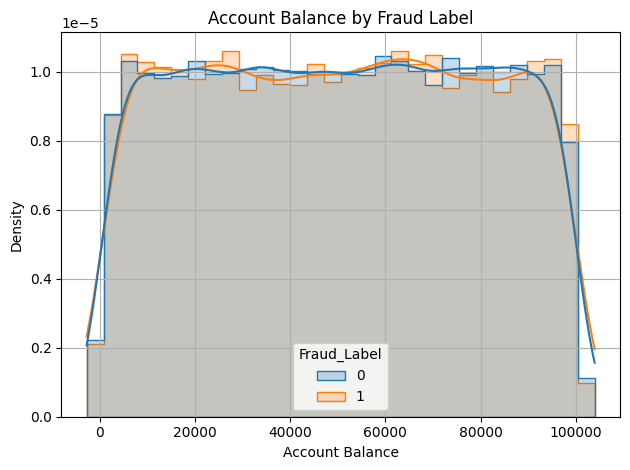

In [16]:
sns.histplot(data=df, x="Account_Balance", hue="Fraud_Label", bins=30, kde=True, element="step", stat="density", common_norm=False)
plt.title("Account Balance by Fraud Label")
plt.xlabel("Account Balance")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** doesn't really help much

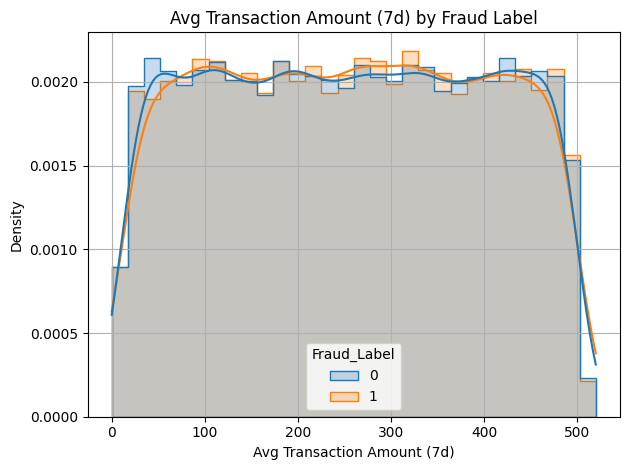

In [17]:
sns.histplot(data=df, x="Avg_Transaction_Amount_7d", hue="Fraud_Label", bins=30, kde=True, element="step", stat="density", common_norm=False)
plt.title("Avg Transaction Amount (7d) by Fraud Label")
plt.xlabel("Avg Transaction Amount (7d)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** doesn't really help much, data is evenly spread

C:\Users\phamr\AppData\Local\Temp\ipykernel_22988\3990535891.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Fraud_Label")


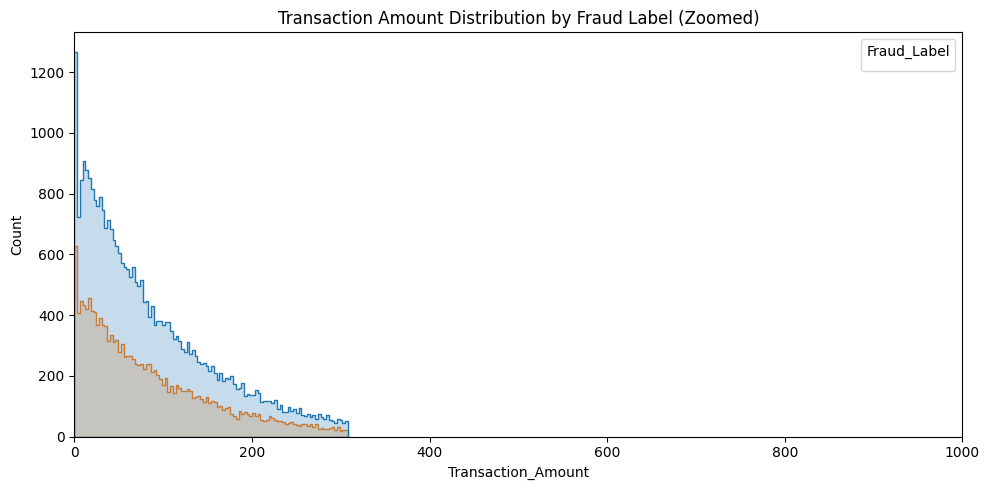

In [18]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Transaction_Amount", hue="Fraud_Label", bins=100, element="step", stat="count", common_norm=False)

# 🔍 Zoom into the region where most data is concentrated
plt.xlim(0, 1000)

plt.title("Transaction Amount Distribution by Fraud Label (Zoomed)")
plt.xlabel("Transaction_Amount")
plt.ylabel("Count")
plt.legend(title="Fraud_Label")
plt.tight_layout()
plt.show()

doesnt help

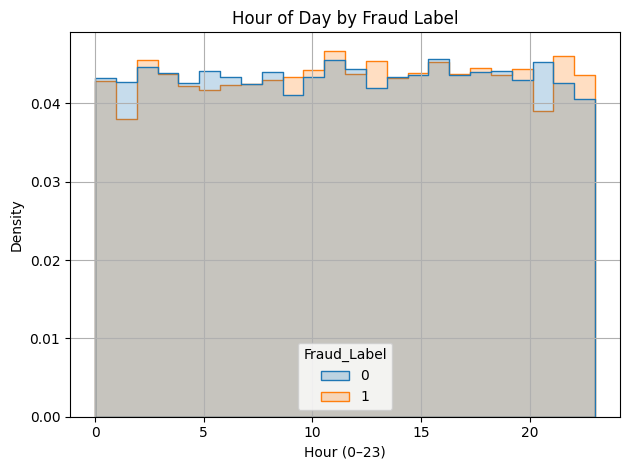

In [19]:
sns.histplot(data=df, x="Hour", hue="Fraud_Label", bins=24, kde=False, element="step", stat="density", common_norm=False)
plt.title("Hour of Day by Fraud Label")
plt.xlabel("Hour (0–23)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Observation:** doesnt help

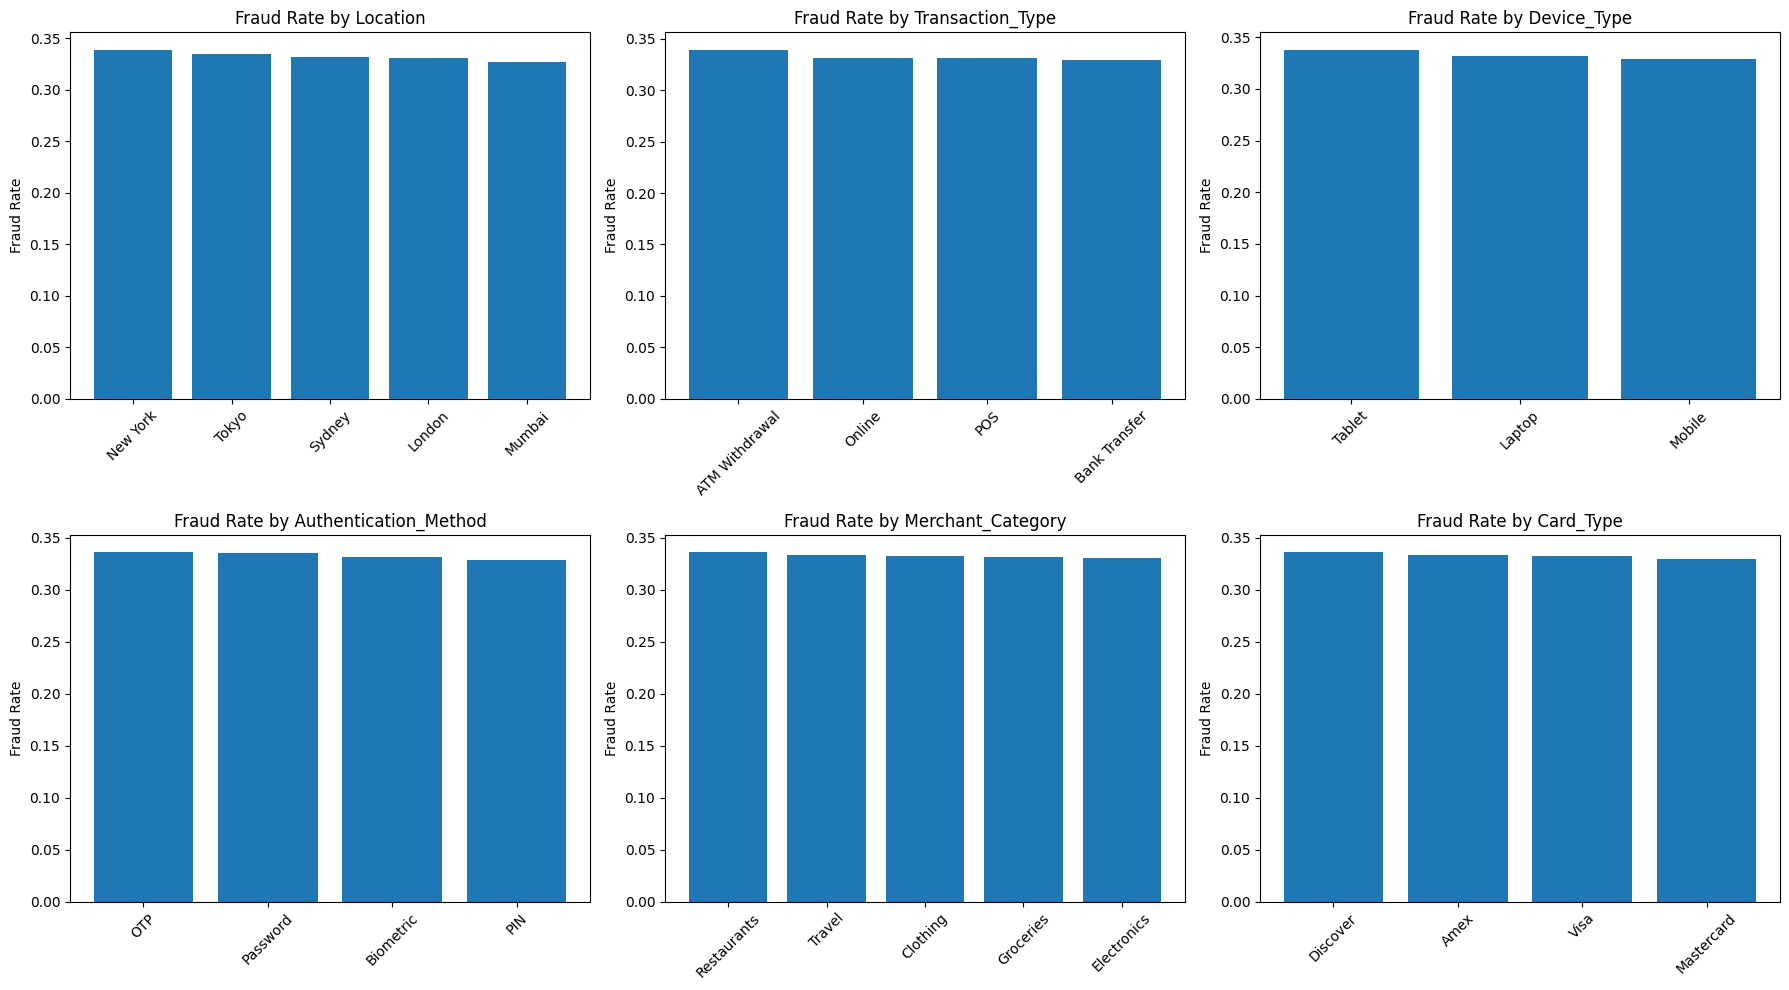

In [20]:
import matplotlib.pyplot as plt

# Prepare categorical columns to visualize
categorical_cols = ["Location", "Transaction_Type", "Device_Type", "Authentication_Method", "Merchant_Category", "Card_Type"]

# Create bar plots showing fraud rate per category
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    fraud_rate = df.groupby(col)["Fraud_Label"].mean().sort_values(ascending=False)
    axes[i].bar(fraud_rate.index, fraud_rate.values)
    axes[i].set_title(f"Fraud Rate by {col}")
    axes[i].set_ylabel("Fraud Rate")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


all are 35 ish percent, doesnt help

In [21]:
# Count of frauds and non-frauds by Location
fraud_by_location = df.groupby(['Location', 'Fraud_Label']).size().unstack(fill_value=0)

# Rename columns for clarity
fraud_by_location.columns = ['Non-Fraud', 'Fraud']

# Display
print(fraud_by_location)


          Non-Fraud  Fraud
Location                  
London         6266   3093
Mumbai         6334   3078
New York       6149   3152
Sydney         6249   3100
Tokyo          6408   3227


## Part 1: Comparing all models

In [22]:
# Define models
classification_models = { 
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Extra Trees': RandomForestClassifier(n_estimators=200),
    'XGBoost': GradientBoostingClassifier(n_estimators=200),  # Use XGBClassifier() if installed
    'Bagging Classifier': RandomForestClassifier(n_estimators=100, bootstrap=True),
    'CatBoost': GradientBoostingClassifier(n_estimators=300),  # Use CatBoostClassifier() if installed
    'LightGBM': GradientBoostingClassifier(n_estimators=400)   # Use LGBMClassifier() if installed
}

# Collect performance
performance = []

for name, model in classification_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    performance.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall': recall_score(y_test, preds, zero_division=0),
        'F1 Score': f1_score(y_test, preds, zero_division=0),
        'AUC-ROC': roc_auc_score(y_test, probs) if probs is not None else None
    })

# Turn into DataFrame
performance_df = pd.DataFrame(performance)
print(performance_df)

                     Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0            Decision Tree  0.923113   0.882218  0.886626  0.884416  0.913927
1            Random Forest  0.959793   0.954666  0.922624  0.938371  0.961171
2        Gradient Boosting  0.959665   0.956342  0.920446  0.938051  0.960325
3                 AdaBoost  0.958900   0.940600  0.935178  0.937881  0.960966
4   Support Vector Machine  0.950017   0.934583  0.913272  0.923805  0.958967
5      K-Nearest Neighbors  0.874787   0.851970  0.753523  0.799728  0.919004
6              Naive Bayes  0.864289   0.817656  0.760569  0.788080  0.913561
7              Extra Trees  0.959750   0.954299  0.922880  0.938326  0.961125
8                  XGBoost  0.958900   0.953936  0.920574  0.936958  0.960200
9       Bagging Classifier  0.959793   0.955753  0.921471  0.938299  0.960689
10                CatBoost  0.958603   0.952570  0.921086  0.936564  0.960569
11                LightGBM  0.958773   0.952595  0.921599  0.936

In [ ]:
# Bar plots for metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    performance_df.sort_values(by=metric, ascending=True, inplace=True)
    plt.barh(performance_df['Model'], performance_df[metric], color='blue')
    plt.xlabel(metric)
    plt.title(f'Model {metric} Comparison')
    plt.grid(True)
    plt.show()

NameError: name 'performance_df' is not defined

<Figure size 1000x600 with 0 Axes>

## Part 2: Handcraft Model
Flag Construction and Rule-Based Prediction

In [9]:
# Binary flags based on visual analysis
df["High_Risk_Score"] = (df["Risk_Score"] > 0.8).astype(int)
df["Extreme_Risk_Score"] = (df["Risk_Score"] > 0.95).astype(int)
df["Mid_High_Amount"] = (df["Transaction_Amount"] < 300).astype(int)
df["FailedTx_Heavy"] = (df["Failed_Transaction_Count_7d"] > 3).astype(int)
df["High_Amount_Fraud_Pattern"] = ((df["Transaction_Amount"] < 300) & (df["Failed_Transaction_Count_7d"] > 3)).astype(int)

In [10]:
# Rule-based model
def final_rule_from_flags(row):
    if row["Extreme_Risk_Score"] == 1:
        return 1
    score = (
        2 * row["High_Risk_Score"] +
        0.5 * row["Mid_High_Amount"] +
        2 * row["FailedTx_Heavy"]+
        1 * row["High_Amount_Fraud_Pattern"]
    )
    return 1 if score >= 2 else 0

df["Predicted_Final"] = df.apply(final_rule_from_flags, axis=1)

## Evaluation of Rule-Based Model

In [11]:
true_labels = df["Fraud_Label"]
predictions = df["Predicted_Final"]

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, zero_division=0)
recall = recall_score(true_labels, predictions, zero_division=0)
f1 = f1_score(true_labels, predictions, zero_division=0)
auc = roc_auc_score(true_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", auc)

Accuracy: 0.9338004246284501
Precision: 0.8700524980829352
Recall: 0.941589530801149
F1 Score: 0.9044086087436385
ROC AUC: 0.9357542055150966


# SQL Integration for Fraud Feature Management

To simulate how real-world financial institutions store and query transaction data, we incorporated SQL into our pipeline using SQLite. We split the dataset into normalized tables—`users`, `transactions`, and `flags`—and used SQL JOINs and conditional queries to analyze high-risk patterns. This step enhanced the realism of our fraud detection workflow and demonstrated our understanding of backend-integrated analytics.

In [38]:

import sqlite3

# Connect to in-memory database
conn = sqlite3.connect(":memory:")

# Create SQL tables
conn.execute("""
CREATE TABLE users (
    User_ID TEXT PRIMARY KEY,
    Location TEXT,
    Device_Type TEXT
);
""")
conn.execute("""
CREATE TABLE transactions (
    Transaction_ID TEXT PRIMARY KEY,
    User_ID TEXT,
    Transaction_Amount REAL,
    Risk_Score REAL,
    Failed_Transaction_Count_7d INTEGER,
    Is_Weekend INTEGER,
    FOREIGN KEY (User_ID) REFERENCES users(User_ID)
);
""")
conn.execute("""
CREATE TABLE flags (
    Transaction_ID TEXT PRIMARY KEY,
    High_Risk_Score INTEGER,
    Mid_High_Amount INTEGER,
    FailedTx_Heavy INTEGER,
    High_Amount_Fraud_Pattern INTEGER,
    FOREIGN KEY (Transaction_ID) REFERENCES transactions(Transaction_ID)
);
""")

# Insert into tables
# Keep only one row per User_ID to prevent Transaction_ID duplication after JOIN
df_users = df[["User_ID", "Location", "Device_Type"]].drop_duplicates(subset="User_ID")
df_transactions = df[["Transaction_ID", "User_ID", "Transaction_Amount", "Risk_Score", "Failed_Transaction_Count_7d", "Is_Weekend", "Fraud_Label"]]
df_flags = df[["Transaction_ID", "High_Risk_Score", "Mid_High_Amount", "FailedTx_Heavy", "High_Amount_Fraud_Pattern"]]

df_users.to_sql("users", conn, index=False, if_exists="replace")
df_transactions.to_sql("transactions", conn, index=False, if_exists="replace")
df_flags.to_sql("flags", conn, index=False, if_exists="replace")

# Example query
import pandas as pd
query = """
SELECT 
    t.Transaction_ID,
    t.User_ID,  
    u.Location,
    t.Risk_Score,
    t.Failed_Transaction_Count_7d,
    t.Is_Weekend,
    f.High_Risk_Score,
    f.Mid_High_Amount,
    f.FailedTx_Heavy,
    f.High_Amount_Fraud_Pattern
FROM transactions t
JOIN flags f ON t.Transaction_ID = f.Transaction_ID
JOIN users u ON t.User_ID = u.User_ID
WHERE t.Risk_Score > 0.8
  AND f.High_Risk_Score = 1
  AND f.FailedTx_Heavy = 1;
"""
pd.read_sql_query(query, conn)


,Transaction_ID,User_ID,Location,Risk_Score,Failed_Transaction_Count_7d,Is_Weekend,High_Risk_Score,Mid_High_Amount,FailedTx_Heavy,High_Amount_Fraud_Pattern
0,TXN_199,USER_2734,Mumbai,0.842458,4.0,1.0,1,1,1,1
1,TXN_15908,USER_4615,New York,0.868954,4.0,1.0,1,1,1,1
2,TXN_47609,USER_4265,New York,0.877050,4.0,1.0,1,1,1,1
3,TXN_30263,USER_8150,London,0.808663,4.0,0.0,1,1,1,1
4,TXN_40485,USER_1299,Mumbai,0.935277,4.0,0.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1854,TXN_21976,USER_7834,Tokyo,0.944804,4.0,0.0,1,1,1,1
1855,TXN_48702,USER_6553,New York,0.991420,4.0,0.0,1,1,1,1
1856,TXN_24300,USER_8742,Sydney,0.860626,4.0,0.0,1,1,1,1
1857,TXN_11534,USER_4052,London,0.983754,4.0,0.0,1,1,1,1


In [33]:
query = """
SELECT 
    User_ID,
    COUNT(*) AS transaction_count
FROM transactions
GROUP BY User_ID
HAVING COUNT(*) > 1
ORDER BY transaction_count DESC;
"""
pd.read_sql_query(query, conn)


,User_ID,transaction_count
0,USER_3925,15
1,USER_9998,14
2,USER_9995,14
3,USER_6906,14
4,USER_6599,14
...,...,...
8692,USER_1084,2
8693,USER_1077,2
8694,USER_1074,2
8695,USER_1039,2


In [35]:
query = """
WITH flagged_txns AS (
    SELECT 
        t.User_ID,
        t.Transaction_ID,
        t.Risk_Score,
        t.Failed_Transaction_Count_7d,
        f.High_Risk_Score,
        f.FailedTx_Heavy,
        t.Fraud_Label
    FROM transactions t
    JOIN flags f ON t.Transaction_ID = f.Transaction_ID
    WHERE t.Risk_Score > 0.8
      AND f.High_Risk_Score = 1
      AND f.FailedTx_Heavy = 1
)
SELECT *
FROM flagged_txns
WHERE User_ID IN (
    SELECT User_ID
    FROM flagged_txns
    GROUP BY User_ID
    HAVING COUNT(*) > 1
)
ORDER BY User_ID;
"""

repeat_users_with_fraud_labels = pd.read_sql_query(query, conn)
repeat_users_with_fraud_labels


,User_ID,Transaction_ID,Risk_Score,Failed_Transaction_Count_7d,High_Risk_Score,FailedTx_Heavy,Fraud_Label
0,USER_1003,TXN_18367,0.878808,4.0,1,1,1
1,USER_1003,TXN_39240,0.858898,4.0,1,1,1
2,USER_1026,TXN_24358,0.825303,4.0,1,1,1
3,USER_1026,TXN_5299,0.867903,4.0,1,1,1
4,USER_1058,TXN_13496,0.926684,4.0,1,1,1
...,...,...,...,...,...,...,...
318,USER_9885,TXN_40121,0.971194,4.0,1,1,1
319,USER_9906,TXN_24383,0.843339,4.0,1,1,1
320,USER_9906,TXN_1691,0.871020,4.0,1,1,1
321,USER_9946,TXN_38033,0.881732,4.0,1,1,1


In [37]:
# Count unique users who have at least one transaction labeled as fraud
num_fraud_users = repeat_users_with_fraud_labels[repeat_users_with_fraud_labels["Fraud_Label"] == 1]["User_ID"].nunique()

print("Number of unique users with repeated flagged transactions who committed fraud:", num_fraud_users)


Number of unique users with repeated flagged transactions who committed fraud: 155


# Hybrid Model

In [28]:
df.dropna(inplace=True)

for col in df.columns:
    if df[col].apply(lambda x: isinstance(x, pd.Interval)).any():
        df[col] = df[col].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
# ----------------------
# Rewriting Rule-based Flags
# ----------------------
df["High_Risk_Score"] = (df["Risk_Score"].astype(float) > 0.8).astype(int)
df["Extreme_Risk_Score"] = (df["Risk_Score"].astype(float) > 0.95).astype(int)
df["Mid_High_Amount"] = (df["Transaction_Amount"] < 300).astype(int)
df["FailedTx_Heavy"] = (df["Failed_Transaction_Count_7d"] > 3).astype(int)
df["High_Amount_Fraud_Pattern"] = (
    (df["Transaction_Amount"] < 300) &
    (df["Failed_Transaction_Count_7d"] > 3)
).astype(int)

# Rule-based logic
def final_rule_from_flags(row):
    if row["Extreme_Risk_Score"] == 1:
        return 1
    score = (
        2 * row["High_Risk_Score"] +
        0.5 * row["Mid_High_Amount"] +
        2 * row["FailedTx_Heavy"] +
        1 * row["High_Amount_Fraud_Pattern"]
    )
    return 1 if score >= 2 else 0

df["Predicted_Final"] = df.apply(final_rule_from_flags, axis=1)

# ----------------------
# Prepare Hybrid Features
# ----------------------
# Drop unnecessary columns and prepare full numeric feature set
X = df.drop(columns=[
    'Fraud_Label', 'Transaction_ID', 'User_ID', 'Transaction_Type', 'Timestamp',
    'Device_Type', 'Location', 'Merchant_Category',
    'Card_Type', 'Authentication_Method'
], errors='ignore')

# Add your rule-based prediction as a feature
X["Rule_Prediction"] = df["Predicted_Final"]

# Target variable
y = df["Fraud_Label"]

# ----------------------
# Train-Test Split & Scaling
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------
# Train Hybrid Model
# ----------------------
model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42
)
model.fit(X_train_scaled, y_train)

# ----------------------
# Evaluate Model
# ----------------------
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, probs)

print("Final Hybrid Model Results")
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))
print("AUC-ROC:", round(auc, 4))


Final Hybrid Model Results
Accuracy: 0.961
Precision: 0.9576
Recall: 0.9235
F1 Score: 0.9403
AUC-ROC: 0.9602


In [29]:
# Select relevant columns 
selected = df[["Risk_Score", "Failed_Transaction_Count_7d", "Fraud_Label"]].dropna()
selected["Risk_Score"] = selected["Risk_Score"].astype(float)

# Take top 20 based on highest Risk_Score
sampled = df.sort_values(by=["Risk_Score", "Failed_Transaction_Count_7d"], ascending=False).head(15)

# Format the output
formatted_outputs = [
    f"Input: ({row['Risk_Score']:.2f}, {row['Failed_Transaction_Count_7d']:.2f}), Actual Label: {int(row['Fraud_Label'])}"
    for _, row in sampled.iterrows()
]

formatted_outputs

['Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 0',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1',
 'Input: (1.00, 4.00), Actual Label: 1']